In [1]:
import pandas as pd

In [2]:
dataset = pd.read_csv(r"E:\Courses\DEPI\New folder\cleansed_dataset.csv")

In [3]:
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.481108,0.657581,-0.424230,0.477799,-0.119148,0.673263,0.462363,0.657862,-0.378397,0.054149,...,-0.382672,-0.337321,0.048415,-0.809509,0.299729,-0.131281,-0.433776,0.025049,-0.350032,1.0
1,-0.040284,-1.244859,0.923571,-1.703976,2.375861,-0.856059,-0.547608,-1.732830,-0.473079,-2.087993,...,-2.324955,1.720734,0.754310,-1.571920,-0.611872,1.154340,1.854666,-2.884976,-0.361522,1.0
2,0.582091,-1.778840,1.815863,-1.703664,0.787731,-1.961016,-1.549548,-1.639628,2.051678,-1.136211,...,1.301630,-1.245272,-0.133151,0.379394,1.161866,-0.699387,1.278390,0.860091,0.050589,1.0
3,-0.017362,-1.312663,1.020788,-1.753761,2.370106,-0.919940,-0.578605,-1.787620,-0.387299,-2.078465,...,-2.320990,1.681640,0.783765,-1.577498,-0.534036,1.170972,1.843232,-2.896932,-0.361522,1.0
4,0.585129,-1.866470,1.865467,-1.758762,0.800600,-2.004977,-1.633239,-1.715618,2.135790,-1.114329,...,1.306632,-1.372288,-0.367747,0.416252,1.135251,-0.714324,1.270177,0.864810,0.050589,1.0


In [4]:
fraudData = dataset[dataset['Class'] == 1]
nonFraudData = dataset[dataset['Class'] == 0]
print(fraudData)
print(nonFraudData)


           Time        V1        V2        V3        V4        V5        V6  \
0      0.481108  0.657581 -0.424230  0.477799 -0.119148  0.673263  0.462363   
1     -0.040284 -1.244859  0.923571 -1.703976  2.375861 -0.856059 -0.547608   
2      0.582091 -1.778840  1.815863 -1.703664  0.787731 -1.961016 -1.549548   
3     -0.017362 -1.312663  1.020788 -1.753761  2.370106 -0.919940 -0.578605   
4      0.585129 -1.866470  1.865467 -1.758762  0.800600 -2.004977 -1.633239   
...         ...       ...       ...       ...       ...       ...       ...   
59400  0.112249 -1.653644  1.500602 -2.002413  2.342949 -1.235434 -0.742050   
59402  1.293942  0.584731 -0.333235  0.360058  0.033471  0.535872  0.602384   
59403  0.731218 -2.856424  2.625548 -2.451223  0.877367 -2.922642 -1.817475   
59404  0.112249 -1.653644  1.500602 -2.002413  2.342949 -1.235434 -0.742050   
59406 -0.277322  0.652987 -0.473863  0.622695  0.014227  0.534337  0.473361   

             V7        V8        V9  ...       V21 

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

In [6]:
xFraudData = fraudData.drop(columns=['Class'])
yFraudData = fraudData['Class']


In [7]:

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))  
xFraudData_scaled = scaler.fit_transform(xFraudData)

def generator(input_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_dim=input_dim), 
        layers.Dense(256, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(30, activation='tanh')  
    ])
    return model
def discriminator(input_dim):
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_dim=input_dim), 
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  
    ])
    return model


def com_gan(generator, discriminator):
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="binary_crossentropy", metrics=['accuracy'])
    discriminator.trainable = False
    
    input_gan = layers.Input(shape=(100,))
    generated_data = generator(input_gan)
    output = discriminator(generated_data)
    
    gan = tf.keras.Model(input_gan, output)
    gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="binary_crossentropy")
    return gan

input_dim_gen = 100  
input_dim_disc = xFraudData_scaled.shape[1] 

generator_model = generator(input_dim=input_dim_gen)
discriminator_model = discriminator(input_dim=input_dim_disc)
ganNetwork = com_gan(generator_model, discriminator_model)

X_train, X_test, y_train, y_test = train_test_split(xFraudData_scaled, yFraudData, test_size=0.3, random_state=42)
epochs = 1000
batch_size = 16

for epoch in range(epochs):
    real_data = X_train[np.random.randint(0, X_train.shape[0], batch_size)]
    real_labels = np.ones((batch_size, 1)) * 0.9 
    noise = np.random.normal(0, 1, (batch_size, input_dim_gen))
    fake_data = generator_model.predict(noise)
    fake_labels = np.zeros((batch_size, 1)) + 0.1  
    d_loss_real = discriminator_model.train_on_batch(real_data, real_labels)
    d_loss_fake = discriminator_model.train_on_batch(fake_data, fake_labels)
    noise = np.random.normal(0, 1, (batch_size, input_dim_gen))
    gan_labels = np.ones((batch_size, 1))  
    g_loss = ganNetwork.train_on_batch(noise, gan_labels)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: [D real loss: {d_loss_real[0]}, acc: {d_loss_real[1]}] [D fake loss: {d_loss_fake[0]}] [G loss: {g_loss}]")


1/1 [==============================] - 0s 142ms/step
Epoch 0: [D real loss: 0.6405705213546753, acc: 0.0] [D fake loss: 0.7475074529647827] [G loss: 0.6473923921585083]
1/1 [==============================] - 0s 34ms/step
Epoch 100: [D real loss: 0.32846271991729736, acc: 0.0] [D fake loss: 0.32603487372398376] [G loss: 2.4300923347473145]
1/1 [==============================] - 0s 16ms/step
Epoch 200: [D real loss: 0.32517528533935547, acc: 0.0] [D fake loss: 0.32571280002593994] [G loss: 2.3460986614227295]
1/1 [==============================] - 0s 27ms/step
Epoch 300: [D real loss: 0.3303908407688141, acc: 0.0] [D fake loss: 0.32521799206733704] [G loss: 2.334981918334961]
1/1 [==============================] - 0s 32ms/step
Epoch 400: [D real loss: 0.3273809254169464, acc: 0.0] [D fake loss: 0.3259889781475067] [G loss: 2.4916534423828125]
1/1 [==============================] - 0s 42ms/step
Epoch 500: [D real loss: 0.32722678780555725, acc: 0.0] [D fake loss: 0.33080440759658813] [G l

In [8]:
noise = np.random.normal(0, 1, (num_samples, input_dim_gen))
synthetic_fraud_data = generator_model.predict(noise)
synthetic_fraud_data_rescaled = scaler.inverse_transform(synthetic_fraud_data)


157/157 [==============================] - 0s 2ms/step


In [9]:
synthetic_labels = np.ones((num_samples, 1))
real_non_fraud_data = nonFraudData.drop(columns=['Class'])
real_non_fraud_labels = nonFraudData['Class']
augmented_X = np.vstack((synthetic_fraud_data_rescaled, real_non_fraud_data))
augmented_y = np.vstack((synthetic_labels, real_non_fraud_labels.values.reshape(-1, 1)))
from sklearn.utils import shuffle
augmented_X, augmented_y = shuffle(augmented_X, augmented_y)


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(augmented_X, augmented_y, test_size=0.3, random_state=42)
classifier = LogisticRegression()
classifier.fit(X_train_aug, y_train_aug.ravel())
y_pred_aug = classifier.predict(X_test_aug)
print(f"Accuracy on augmented dataset: {accuracy_score(y_test_aug, y_pred_aug)}")
print("Classification Report:")
print(classification_report(y_test_aug, y_pred_aug))


Accuracy on augmented dataset: 0.9998079139454475
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8941
         1.0       1.00      1.00      1.00      1471

    accuracy                           1.00     10412
   macro avg       1.00      1.00      1.00     10412
weighted avg       1.00      1.00      1.00     10412



In [11]:
X_real = dataset.drop(columns=['Class'])
y_real = dataset['Class']

X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_real, y_real, test_size=0.3, random_state=42)

classifier.fit(X_train_real, y_train_real)
y_pred_real = classifier.predict(X_test_real)

print(f"Accuracy on original dataset: {accuracy_score(y_test_real, y_pred_real)}")
print("Classification Report on Original Dataset:")
print(classification_report(y_test_real, y_pred_real))


Accuracy on original dataset: 0.9699826067440948
Classification Report on Original Dataset:
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      8899
         1.0       0.98      0.96      0.97      8924

    accuracy                           0.97     17823
   macro avg       0.97      0.97      0.97     17823
weighted avg       0.97      0.97      0.97     17823



In [12]:
synthetic_fraud_data = pd.DataFrame(synthetic_fraud_data)

In [13]:
# Combine real and synthetic fraud data
balanced_fraud_data = pd.concat([fraudData, synthetic_fraud_data])


In [14]:

balanced_dataset = pd.concat([balanced_fraud_data, nonFraudData])
class_distribution_balanced = balanced_dataset['Class'].value_counts()
print(class_distribution_balanced)


Class
1.0    29704
0.0    29704
Name: count, dtype: int64


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

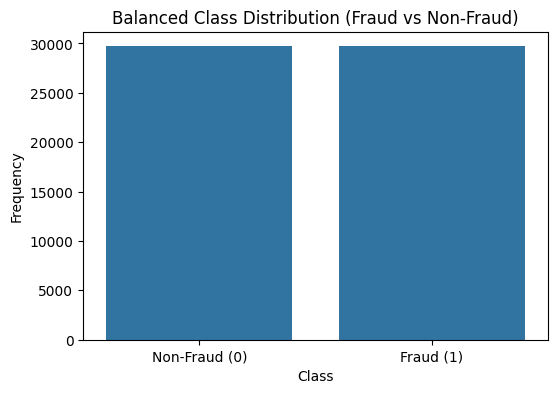

In [16]:
# Plot the new class distribution
plt.figure(figsize=(6,4))
sns.barplot(x=class_distribution_balanced.index, y=class_distribution_balanced.values)
plt.title('Balanced Class Distribution (Fraud vs Non-Fraud)')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()
